# LBT Target Visibility Calculator

This uses John Thorstensen's `thorsky` package (https://github.com/jrthorstensen/thorsky).


`thorsky` is built on `astropy.coordinates`, `astropy.time`, and `astropy.units` and comprises of two
classes, `thorskyclasses3` and `thorskyutil`, the latter of which uses faster but sufficiently accurate
versions of analgous functions from `astropy.coordinates` that are high-precision but slow (LST, moon and sun 
positions, and barycentric calculations). We don't need high precision for this type of calculation.

Other dependences are `dateutils` and `pytz` which come with the Anaconda distro so should be transparent.

**Note**: it needs `astropy` 5.2 or later as a bug in 5.1 kills this package at initialization.

See the `thorsky` documentation if you need to dig deeper, change the observatory site, etc.


In [2]:
import numpy as np
import math

import thorsky.thorskyclasses3 as tsc3
import thorsky.thorskyutil as tsu

# astropy units, time, and angles (thorsky needs "u" for units)

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import Angle

# graphics

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter
from matplotlib import rcParams

# this lets us use quantities and units with matplotlib, which is very helpful here

from astropy.visualization import quantity_support
quantity_support()

from astropy.visualization import time_support
time_support()

# interpolation

from scipy.interpolate import splev, splrep

# graphics setup for matplotlib

# aspect ratio = width/height

aspect = 16.0/9.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 8.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'10'})

# Font and line weight defaults for axes

plt.rcParams.update({'axes.linewidth':lwidth})
plt.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']='%d' % (axisPad)
plt.rcParams['ytick.major.pad']='%d' % (axisPad)
plt.rcParams['axes.labelpad'] = '%d' % (axisPad)

# throttle warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Target coordinates

Set coordinates using the `obs.setcelest()` method. Coordinates given without epoch default to ICRS 
(J2000 without an equinox).

Set the observation time using the `obs.settime()` method.  Two options:
 * `obs.settime("2018-09-14 13:14:15")` for local time ("local" defined by `obs.setsite()`)
 * `obs.settime("2018-09-14 13:14:15", use_local_time = False)` to set to UTC date/time

Time setting should follow ISO-8601 format.

Below we compute circumstances for the target for every half hour from before sunset to just after
sunrise.

In [3]:
# target coordinates

obsSite = 'lbt'

# Feb26 run

objID = 'WISEA J0736+2430'
objCoords = ['07:36:42.421','+24:30:22.42']

objID = 'WISEA J0743+2606'
objCoords = ['07:43:04.418','+26:05:44.99']

objID = 'SDSS J1347+1630'
objCoords = ['13:47:00.862','+16:30:15.37']

objID = 'SDSS J1407+2814'
objCoords = ['14:07:38.083','+28:14:46.14']

objID = 'SDSS J1116+1409'
objCoords = ['11:16:13.716','+14:09:05.07']

objID = "Leo P (LP26)"
objCoords = ["10:21:45.122","+18:05:16.93"]

# Jan 26 run

#objID = 'SDSS J1044+0353'
#objCoords = ['10:44:57.795','03:53:13.19']

#objID = 'SDSS J1049+1038'
#objCoords = ['10:49:53.005','10:38:37.04']

#objID = ''
#objCoords = ['','']

#-------------

objRA = objCoords[0]   
objDec = objCoords[1]
obsDate = '2026-02-17' # local time
obsTime = '23:59:59'   # set to '23:59:59' for near midnight

# use a maximum airmass limit

maxAM = 1.5
useMaxAM = True

# set True for quick diagnostics or detailed circumstances at obsDate/obsTime

showCurrent = False # to show circumstances at local midnight on obsDate (noisy!)

# --- end user settings ---

# instantiate an obs object for LBT

obs = tsc3.Observation(site=obsSite)  

# LBT elevation limits

lbtMaxEl = 85.0 # maximum elevation in degrees
lbtMinEl = 30.0 # minimum working elevation in degrees
lbtUMinEl= 25.0 # ultimate minimum elevation in degrees

# elevation of airmass 1.5 - pedantic to make the math obvious

elAM15 = 90.0 - np.degrees(np.arccos(1.0/1.5))

# timezone for the site

tz = obs.site.localtz

# start object specific setup

obs.setcelest(f'{objRA} {objDec}')
obs.settime(f'{obsDate} {obsTime}')


raStr = obs.celest.ra.to_string(unit = u.hourangle, sep = ':',pad=True, precision=2)
decStr = obs.celest.dec.to_string(sep = ':', precision=1, pad=True, alwayssign=True)

print(f'  Target: {objID}')
print(f'  Coords: {raStr} {decStr} {obs.celest.frame.name}')
print(f'          {obs.celest.ra.value:.6f}d {obs.celest.dec.value:+.6f}d')
print(f'Obs Date: {obsDate} MST ({obs.t.to_datetime().strftime("%Y-%m-%d")} UTC)')

# show current observation cirumstances, False if doing advanced planning

if showCurrent:
    print('\nCircumstances Now:')
    obs.printnow()
    
# hourly circumstances

obs.computesky()
obs.computesunmoon()
obs.setnightevents()

# Night summary

print(f'\nLBT Almanac for {obsDate} MST')

sunset = obs.tsunset.to_datetime(timezone = tz)
print(f'         Sunset: {tsu.time_rounded_to_minute(sunset)} MST')

endtwi12 = obs.tevetwi12.to_datetime(timezone = tz) 
print(f' 12-degree Dusk: {tsu.time_rounded_to_minute(endtwi12)} MST')

endtwi = obs.tevetwi.to_datetime(timezone = tz) 
print(f'  Twilight Ends: {tsu.time_rounded_to_minute(endtwi)} MST')

nghtctr = obs.tnightcenter.to_datetime(timezone = tz)
print(f'Center of Night: {tsu.time_rounded_to_minute(nghtctr)} MST')

begtwi = obs.tmorntwi.to_datetime(timezone = tz)
print(f'Twilight Begins: {tsu.time_rounded_to_minute(begtwi)} MST')

begtwi12 = obs.tmorntwi12.to_datetime(timezone = tz) 
print(f' 12-degree Dawn: {tsu.time_rounded_to_minute(begtwi12)} MST')

sunrise = obs.tsunrise.to_datetime(timezone = tz)
print(f'        Sunrise: {tsu.time_rounded_to_minute(sunrise)} MST')

moonrise = obs.tmoonrise.to_datetime(timezone = tz)
print(f'       Moonrise: {tsu.time_rounded_to_minute(moonrise)} MST')
      
moonset = obs.tmoonset.to_datetime(timezone = tz)
print(f'        Moonset: {tsu.time_rounded_to_minute(moonset)} MST')
print(f'     Moon Phase: {obs.moonphasedescr} ({100*obs.moonillumfrac:.1f}%)')

# Target visibility summary

print(f'\nVisibility Summary:')

obs.compute_hours_up()
minEl,maxEl = tsu.min_max_alt(obs.site.location.lat,obs.celnow.dec)

if minEl.degree < lbtMinEl and maxEl.degree >= lbtMinEl: # LBT minimum elevation 
    ha_minEl = tsu.ha_alt(obs.celnow.dec,obs.site.location.lat,Angle(lbtMinEl,u.degree))
    ha_uminEl = tsu.ha_alt(obs.celnow.dec,obs.site.location.lat,Angle(lbtUMinEl,u.degree))
    print(f'  Above El=30 for {24.0*obs.uptime20.value:.1f} h from HA -{ha_minEl.hour:.2f} to +{ha_minEl.hour:.2f} h')
    print(f'  Above El=25 for {2.0*ha_uminEl.hour:.1f} h from HA -{ha_uminEl.hour:.2f} to +{ha_uminEl.hour:.2f} h')

elif minEl.degree < lbtMinEl and maxEl.degree >= lbtUMinEl:
    ha_uminEl = tsu.ha_alt(obs.celnow.dec,obs.site.location.lat,Angle(lbtUMinEl,u.degree))
    print(f'  Above El=25 for {2.0*ha_uminEl.hour:.1f} h from HA -{ha_uminEl.hour:.2f} to +{ha_uminEl.hour:.2f} h')
    print(f'  Always below El=30')
    
elif minEl.degree >= lbtMinEl:
    print(f'  Always above El=30 degrees')

else:
    print(f'  *** Never visible from LBT: always below El={lbtUMinEl:.0f} deg')

if maxEl.degree > lbtMaxEl: # LBT max elevation limit
    ha_maxEl = tsu.ha_alt(obs.celnow.dec,obs.site.location.lat,Angle(lbtMaxEl,u.degree))
    t_maxEl = 2.0*ha_maxEl.hour
    if t_maxEl < 1.0:
        print(f'  Above El={lbtMaxEl:.0f} for {60*t_maxEl:.0f} minutes from HA -{ha_maxEl.hour:.1f} to +{ha_maxEl.hour:.1f} h')       
    else:
        print(f'  Above El={lbtMaxEl:.0f} for {t_maxEl:.2f} hours from HA -{ha_maxEl.hour:.2f} to +{ha_maxEl.hour:.2f} h')
else:
    print(f'  Always below El={lbtMaxEl:.0f} deg')

# check airmass 1.5, common observing limit

if minEl.degree < elAM15 and maxEl.degree >= elAM15:
    ha_am15 = tsu.ha_alt(obs.celnow.dec,obs.site.location.lat,Angle(elAM15, u.degree))
    print(f'  Above AM=1.5 for {24.0*obs.uptime15.value:.1f} h from -{ha_am15.hour:.2f} to +{ha_am15.hour:.2f} h')
elif minEl.degree >= elAM15:
    print(f'  Always above 1.5 Airmass')
else:
    print(f'  Always below 1.5 Airmass')

# make the table header
      
print(f'\nCircumstances for {objID}:\n')
      
print(f' MST    UTC     HA     secz    Elev    parAng/revAng  sunEL moonEl moonAng moonMag')

# start time rounded hour of sunset and 1 hour rounded after sunrise

dtSsSr = 24 + (sunrise.hour + 1) - (sunset.hour)
numTimes = 2*dtSsSr + 1

startDate = sunset.strftime("%Y-%m-%d")
endDay = sunrise.strftime("%d")
startTime = Time(f'{sunset.strftime("%Y-%m-%d")} {sunset.hour}:00')
endTime = Time(f'{sunrise.strftime("%Y-%m-%d")} {sunrise.hour+1}:00')
obsRange = np.linspace(startTime,endTime,numTimes,endpoint=True)

# Data arrays for post-processing

jd = []
utc = []
ha = []
am = []
el = []
parUp = []
parDn = []

for obsTime in obsRange:
    obs.settime(obsTime.strftime("%Y-%m-%d %H:%M"))
    obs.computesky()
    utcTime = obs.t.to_datetime().strftime("%H:%M")
    obsHA = obs.hanow.value
    obs.airmass
    if obs.airmass > 0.0:
        obsAM = f'{obs.airmass:6.2f}'
    else:
        obsAM = '(down)'
        
    obsEl = obs.altit.to(u.degree).value
    if obsEl > 0:
        obsAlt = f'{obsEl:6.2f}'
    else:
        obsAlt = '(down)'
        
    parAng = obs.parang.to(u.degree).value
    if parAng < 0:
        revAng = 180+parAng
    else:
        revAng = parAng-180
        
    obs.computesunmoon()
    sunEl = obs.sunaltit.to(u.degree).value
    if sunEl < -18.0:
        sunAlt = ' ... '
    else:
        sunAlt = f'{sunEl:5.1f}'
    twiMag = obs.twi
    moonEl = obs.moonaltit.to(u.degree).value
    if moonEl < 0:
        moonAlt = ' ... '
        moonAng = ' ... '
        moonMag = ' ... '
    else:
        moonAlt = f'{moonEl:5.1f}'
        moonAng = f'{obs.moonobjang.to(u.degree).value:5.1f}'
        if obs.lunsky > 24:
            moonMag = ' ... '
        else:
            moonMag = f'{obs.lunsky:5.2f}'
        
    print(f'{obsTime.strftime("%H:%M")}  {utcTime}  {obsHA:6.2f}  {obsAM}  {obsAlt}  {parAng:7.2f}/{revAng:7.2f} {sunAlt}  {moonAlt}  {moonAng}  {moonMag}')  

    utc.append(obs.t.to_datetime())
    jd.append(obs.t.jd)
    ha.append(obsHA)
    am.append(obs.airmass)
    el.append(obsEl)
    parUp.append(parAng)
    parDn.append(revAng)
    
# next cell does plotting

  Target: Leo P (LP26)
  Coords: 10:21:45.12 +18:05:16.9 icrs
          155.438008d +18.088036d
Obs Date: 2026-02-17 MST (2026-02-18 UTC)

LBT Almanac for 2026-02-17 MST
         Sunset: 18:12 MST
 12-degree Dusk: 19:01 MST
  Twilight Ends: 19:30 MST
Center of Night: 00:33 MST
Twilight Begins: 05:37 MST
 12-degree Dawn: 06:05 MST
        Sunrise: 06:54 MST
       Moonrise: 07:35 MST
        Moonset: 18:40 MST
     Moon Phase: 0.8 days since new moon (0.7%)

Visibility Summary:
  Above El=30 for 8.7 h from HA -4.36 to +4.36 h
  Above El=25 for 9.5 h from HA -4.76 to +4.76 h
  Always below El=85 deg
  Above AM=1.5 for 6.8 h from -3.42 to +3.42 h

Circumstances for Leo P (LP26):

 MST    UTC     HA     secz    Elev    parAng/revAng  sunEL moonEl moonAng moonMag
18:00  01:00   -6.84  (down)  (down)   -55.19/ 124.81   0.6    6.0  172.1   ... 
18:30  01:30   -6.34    9.45    5.45   -57.34/ 122.66  -5.6    0.1  171.9   ... 
19:00  02:00   -5.84    4.87   11.53   -59.10/ 120.90 -11.8   ...    

###### more processing?

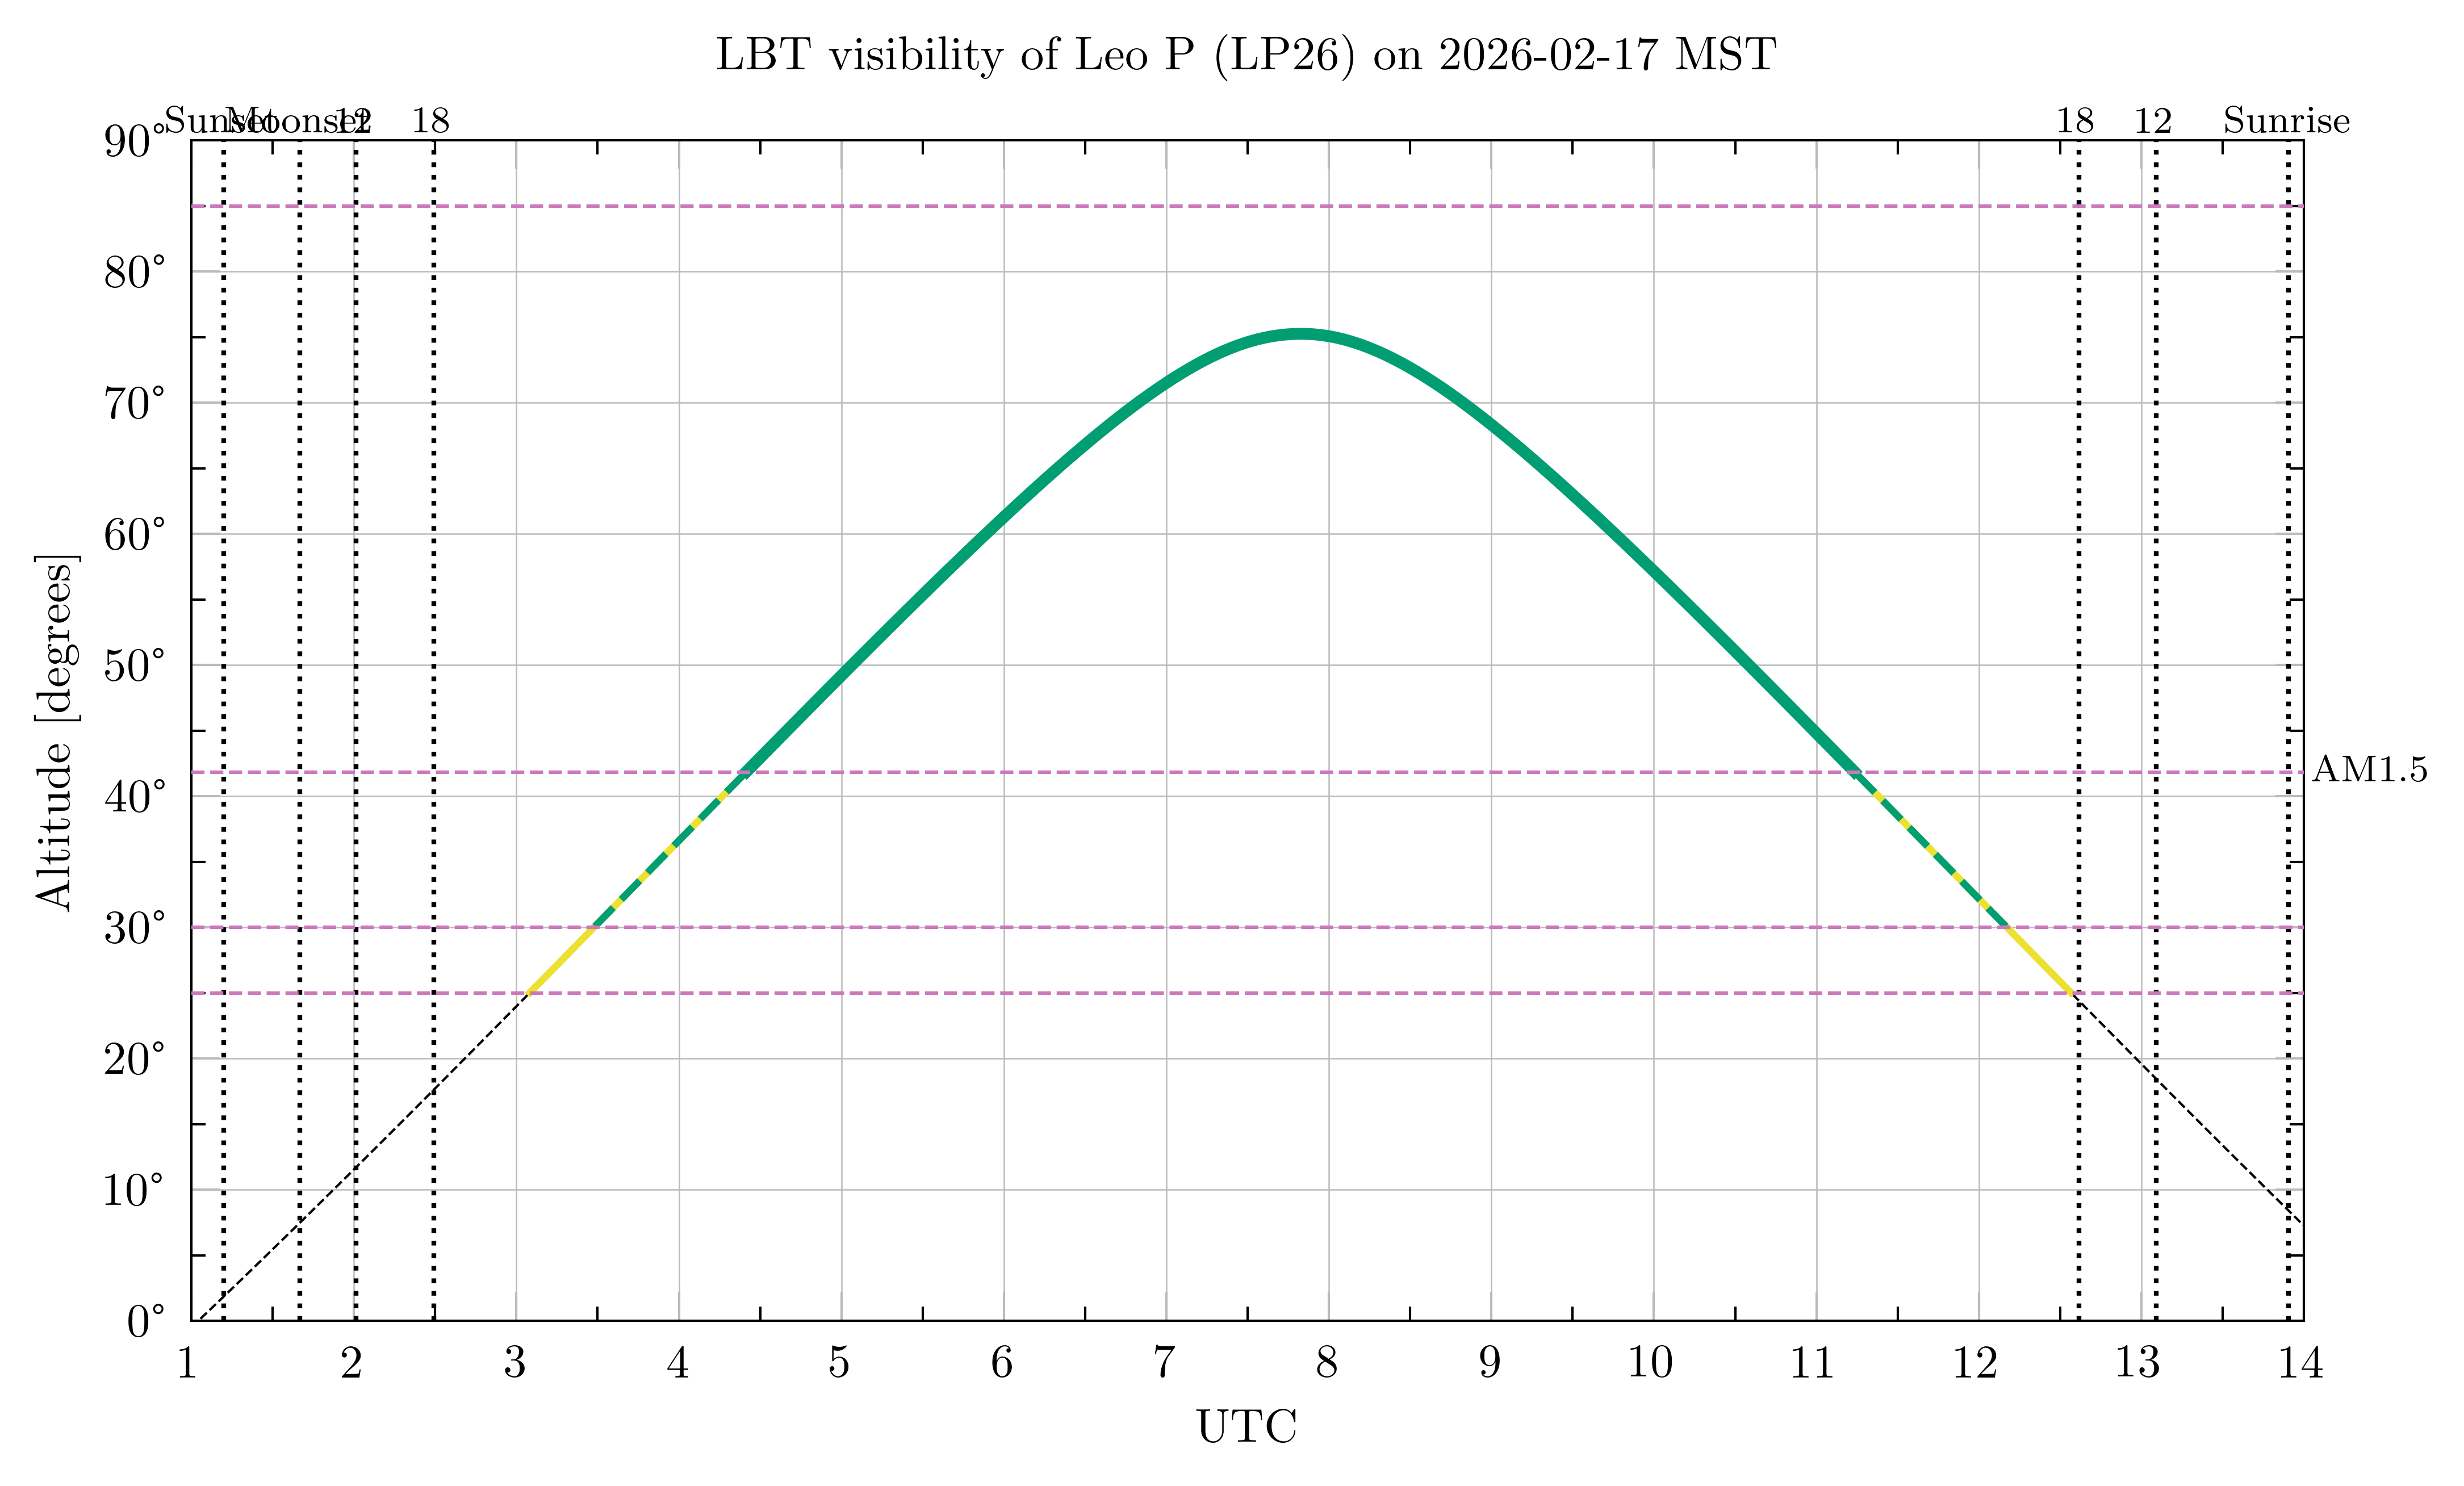

In [4]:
jdMin = jd[0]
jdMax = jd[-1]
utcMin = utc[0].hour
utcMax = utc[-1].hour

tSS = obs.tsunset.jd
utcSS = utcMin + 24.0*(tSS - jdMin)
evet12 = obs.tevetwi12.jd
utcE12 = utcMin + 24.0*(evet12 - jdMin)
evet18 = obs.tevetwi.jd
morn18 = obs.tmorntwi.jd
morn12 = obs.tmorntwi12.jd
utcM12 = utcMin + 24.0*(morn12 - jdMin)
tSR = obs.tsunrise.jd
utcSR = utcMin + 24.0*(tSR - jdMin)
tMR = obs.tmoonrise.jd
tMS = obs.tmoonset.jd

almanac = np.array([tSS,evet12,evet18,morn18,morn12,tSR,tMR,tMS])
almLabels = ['Sunset','12','18','18','12','Sunrise','Moonrise','Moonset']

tUTC = utcMin + 24.0*(jd - jdMin)
almUTC = utcMin + 24.0*(almanac - jdMin)

# Interpolate elevation vs. time onto a 1-minute grid

numSm = int(60*(utcMax-utcMin))+1

spl = splrep(tUTC,el)
smUTC = np.linspace(utcMin,utcMax,numSm)
smEl = splev(smUTC,spl)

# Make the plot

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

# setup grid and ticks

gridColor = '#bbbbbb'

ax.tick_params('both',length=6,width=0.5,which='major',direction='in',top='on',right='on',
               grid_linestyle='-',grid_linewidth=0.3,grid_color=gridColor,color=gridColor)

ax.tick_params('both',length=3,width=0.5,which='minor',direction='in',top='on',right='on')

ax.set_title(f'LBT visibility of {objID} on {obsDate} MST',fontsize=axisFontSize,pad=15)

# x-axis is local time from 1 hour before sunset to 1 hour after sunrise, ticks every hour

ax.set_xlim(utcMin,utcMax) 
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_xlabel(f'UTC')

# y-axis is altitude from horizon (alt=0) to zenith (alt=90)

ax.set_ylim(0*u.deg, 90*u.deg)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_ylabel('Altitude [degrees]')

ax.grid(True)

# plot the smoothed elevation track with time, base curve is thin dashed black, width 0.5, top-3 layer

ax.plot(smUTC,smEl*u.degree,'--',lw=0.5,color='black',zorder=7)

# Color curve by visibility events

iMax = np.argmax(smEl) # index of maximum elevation, splits curve into two halves
smUTMax = smUTC[iMax]  # time of maximum elevation

# Basic visibility: above LBT minimum elevation in green = visible (top-1 layer)

if maxEl.degree >= lbtMinEl:
    iVis = np.where(smEl >= lbtMinEl)[0]
    if useMaxAM:
        ax.plot(smUTC[iVis],smEl[iVis]*u.degree,'--',lw=1.5,color='#029E73',zorder=9)
    else:
        ax.plot(smUTC[iVis],smEl[iVis]*u.degree,'-',lw=1.5,color='#029E73',zorder=9)

# are we showing only below a maximum Airmass

if useMaxAM:
    if maxEl.degree >= elAM15:
        iVis = np.where(smEl >= elAM15)[0]
        ax.plot(smUTC[iVis],smEl[iVis]*u.degree,'-',lw=2.5,color='#029E73',zorder=9)

# above ultimate elevation minimum in amber (top-2 layer)

if maxEl.degree >= lbtUMinEl:
    iuVis = np.where(smEl >= lbtUMinEl)[0]
    ax.plot(smUTC[iuVis],smEl[iuVis]*u.degree,'-',lw=1.5,color='#ECE133',zorder=8)

# above maximum elevation limit in red (top layer)

if maxEl.degree >= lbtMaxEl:
    imVis = np.where(smEl >= lbtMaxEl)[0]
    ax.plot(smUTC[imVis],smEl[imVis]*u.degree,'-',lw=1.5,color='#D95F02',zorder=10)

# formal visibility extends before 12-degree evening twilight

iDusk = np.where((smUTC < utcE12) & (smEl > lbtUMinEl))[0]
if len(iDusk) > 0:
   ax.plot(smUTC[iDusk],smEl[iDusk]*u.degree,'-',lw=1.5,color='#D95F02',zorder=10) 

# formal visibility extends beyond 12-degree morning twilight

iDawn = np.where((smUTC > utcM12) & (smEl > lbtUMinEl))[0]
if len(iDawn) > 0:
   ax.plot(smUTC[iDawn],smEl[iDawn]*u.degree,'-',lw=1.5,color='#D95F02',zorder=10) 

# formal visibility extends before sunset

iSet = np.where((smUTC < utcSS) & (smEl > lbtUMinEl))[0]
if len(iSet) > 0:
   ax.plot(smUTC[iSet],smEl[iSet]*u.degree,'-',lw=1.5,color='#D95F02',zorder=10) 

# formal visibility extends beyond sunrise

iRise = np.where((smUTC > utcSR) & (smEl > lbtUMinEl))[0]
if len(iRise) > 0:
   ax.plot(smUTC[iRise],smEl[iRise]*u.degree,'-',lw=1.5,color='#D95F02',zorder=10) 

# annotation with elevation limits and almanac events (sunrise et al.)

ax.hlines([lbtUMinEl,lbtMinEl,lbtMaxEl],utcMin,utcMax,ls=['--'],colors=['#CC78BC'],lw=0.75,zorder=9)
ax.vlines(almUTC,0*u.deg,90*u.deg,ls=[':'],colors=['black'],lw=1,zorder=8)
for i in range(len(almUTC)):
    if almUTC[i]>utcMin and almUTC[i]<utcMax:
        ax.text(almUTC[i],90*u.deg,almLabels[i],fontsize=8,va='bottom',ha='center')

if useMaxAM:
    ax.hlines(elAM15,utcMin,utcMax,ls=['--'],colors=['#CC78BC'],lw=0.75,zorder=9)
    ax.text(utcMax+0.05,elAM15,'AM1.5',va='center',ha='left',fontsize=8)

# make a hardcopy

pngFile = f'{objID.replace(" ","")}_{obsDate.replace("-","")}_vis.png'
pngFile = f'{objID.replace(" ","")}_vis.png'

plt.savefig(pngFile,bbox_inches='tight',facecolor='white')

plt.show()